In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ライブラリインポート

In [2]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import re
import plotly.express as px
import random
import gc

## 擬似乱数の定義

In [3]:

def set_seed(seed=200):
    tf.random.set_seed(seed)

    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


set_seed(54321)

## データセット準備

In [5]:
label_dict_df = pd.read_csv("./drive/MyDrive/sueki_data/sueki_label.csv", index_col=0)
display.display(label_dict_df)

,身・蓋,列品番号,型式,年代（6世紀）,向き,データセット,class_type,class_age
0,futa,J-6564,Ⅱ－３,中葉,1,train,2,1
1,futa,J-6568,Ⅱ－３,中葉,1,train,2,1
2,futa,J-6569,Ⅱ－５,後葉,1,train,4,2
3,futa,J-6570,Ⅱ－４,後葉,1,valid,3,2
4,futa,J-6572,Ⅱ－３,中葉,1,valid,2,1
...,...,...,...,...,...,...,...,...
103,mi,J-3650,Ⅱ－５,後葉,0,train,4,2
104,mi,J-11536,Ⅱ－５,後葉,0,train,4,2
105,mi,J-22896-19,Ⅱ－５,後葉,0,train,4,2
106,mi,J-22896-21,Ⅱ－５,後葉,0,train,4,2


In [ ]:
!unzip -q ./drive/MyDrive/sueki_data/sueki_64voxel_dataset.zip

## 須恵器Voxelの可視化例

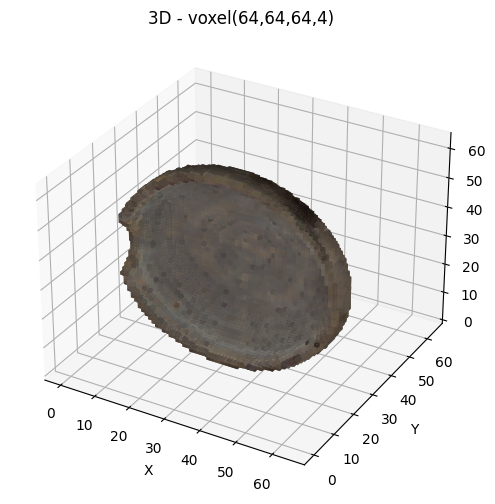

In [6]:
def plot_voxel(matrix, matrix_size=32):

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d', aspect='auto')

    facecolors = matrix / 255
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = np.indices(np.array(filled.shape) + 1)

    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
    ax.set_title("3D - voxel({},{},{},4)".format(matrix_size, matrix_size, matrix_size))
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

#注：本サンプルデータの須恵器はY座標が縦軸である
plot_voxel(matrix = np.load("./data/voxel/futa_J-11536_4_2_64_000.npy"), matrix_size=64)

## データセットペアの作成

In [7]:
BUFFER_SIZE = 20
BATCH_SIZE = 32
EPOCHS = 50
DATA_DIR = "./data/voxel"
VOXEL_SIZE = 64
NUM_CHANNELS = 4

# 須恵器の型式ラベル
categories1 = ['Ⅱ－１','Ⅱ－２','Ⅱ－３','Ⅱ－４','Ⅱ－５']

# Voxelファイルパスの取得準備
cat_re = re.compile(r'.+/.+_(.+?)_[0-9]_[0-9]_[0-9]+_[0-9]+\.npy')

# part A のデータセット準備
train_pattern_part_A = DATA_DIR +'/{}_*_{}_*.npy'.format("futa", VOXEL_SIZE)
train_list_ds_part_A = tf.data.Dataset.list_files(train_pattern_part_A, shuffle = False)


train_labels_part_A = [label_dict_df.loc[label_dict_df["列品番号"] == cat_re.match(item.numpy().decode())[1], ["型式","年代（6世紀）"]].to_numpy().tolist()[0] for item in train_list_ds_part_A]
train_ids_part_A = [categories1.index(cat[0]) for cat in train_labels_part_A]
train_label_ds_part_A = tf.data.Dataset.from_tensor_slices(tf.cast(train_ids_part_A, tf.float32))


# part B のデータセット準備
train_pattern_part_B = DATA_DIR +'/{}_*_{}_*.npy'.format("mi", VOXEL_SIZE)
train_list_ds_part_B = tf.data.Dataset.list_files(train_pattern_part_B, shuffle = False)

train_labels_part_B = [label_dict_df.loc[label_dict_df["列品番号"] == cat_re.match(item.numpy().decode())[1], ["型式","年代（6世紀）"]].to_numpy().tolist()[0] for item in train_list_ds_part_B]
train_ids_part_B = [categories1.index(cat[0]) for cat in train_labels_part_B]
train_label_ds_part_B = tf.data.Dataset.from_tensor_slices(tf.cast(train_ids_part_B, tf.float32))

# ラベルを1-hotエンコーディングに変換
def one_hot_encode_label(label):
    label = tf.one_hot(tf.cast(label, dtype = tf.int32), depth = len(categories1))
    return label

train_label_ds_part_A = train_label_ds_part_A.map(one_hot_encode_label)
train_label_ds_part_B = train_label_ds_part_B.map(one_hot_encode_label)


# 0-255の値を0-1へ正規化
def read_npy_file(path):
    voxel_data = np.load(path.numpy())
    data = voxel_data / 255.0
    return tf.convert_to_tensor(data, dtype=tf.float32)

train_3d_ds_part_A = train_list_ds_part_A.map(
        lambda item: tf.py_function(read_npy_file, [item], tf.float32) )

train_3d_ds_part_B = train_list_ds_part_B.map(
        lambda item: tf.py_function(read_npy_file, [item], tf.float32) )

train_3d_ds_part_A = train_3d_ds_part_A.map(lambda x: tf.ensure_shape(x, (VOXEL_SIZE, VOXEL_SIZE, VOXEL_SIZE, NUM_CHANNELS)))
train_3d_ds_part_B = train_3d_ds_part_B.map(lambda x: tf.ensure_shape(x, (VOXEL_SIZE, VOXEL_SIZE, VOXEL_SIZE, NUM_CHANNELS)))

len_dataset_part_A = train_3d_ds_part_A.cardinality().numpy()
len_dataset_part_B = train_3d_ds_part_B.cardinality().numpy()


# データセットの長さ（データ数）が多い方へ合わせる
if len_dataset_part_A > len_dataset_part_B:
    len_dataset = len_dataset_part_A
else:
    len_dataset = len_dataset_part_B

print(f"len_dataset_part_A : {len_dataset_part_A}")
print(f"len_dataset_part_B : {len_dataset_part_B}")
print(f"len_dataset : {len_dataset}")

# データセットの長さ（データ数）が多い方へ合わせつつ，
# 3Dデータセットの読み込みとラベルデータセットを結合（それぞれシャッフル）
dataset_part_A = tf.data.Dataset.zip((train_3d_ds_part_A, train_label_ds_part_A)).shuffle(buffer_size = BUFFER_SIZE).take(len_dataset)
dataset_part_B = tf.data.Dataset.zip((train_3d_ds_part_B, train_label_ds_part_B)).shuffle(buffer_size = BUFFER_SIZE).take(len_dataset)

# 2つのデータセットをzipで結合，2つの入力・2つの出力を1つのデータセットへ
combined_dataset = tf.data.Dataset.zip((dataset_part_A, dataset_part_B))

combined_dataset = combined_dataset.map(lambda part_A, part_B: (
    {"part_A": part_A[0], "part_B": part_B[0]},
    {"part_A": part_A[1], "part_B": part_B[1]}
))

combined_dataset = combined_dataset.batch(BATCH_SIZE)

# データセットの中身を確認
for data, label in combined_dataset.take(1):
    print("Input keys:", data.keys())  # 入力辞書のキーを確認
    print("Input part_A shape:", data["part_A"].shape)
    print("Input part_B shape:", data["part_B"].shape)
    print("Output keys:", label.keys())  # 出力辞書のキーを確認
    print("Output part_A shape:", label["part_A"].shape)
    print("Output part_B shape:", label["part_B"].shape)


len_dataset_part_A : 588
len_dataset_part_B : 708
len_dataset : 708
Input keys: dict_keys(['part_A', 'part_B'])
Input part_A shape: (32, 64, 64, 64, 4)
Input part_B shape: (32, 64, 64, 64, 4)
Output keys: dict_keys(['part_A', 'part_B'])
Output part_A shape: (32, 5)
Output part_B shape: (32, 5)


# 対照学習用モデル定義・訓練

In [8]:
# モデルていｋ
class VoxelModel(tf.keras.Model):
    def __init__(self):
        super(VoxelModel, self).__init__()

        self.conv1 = tf.keras.layers.Conv3D(filters = 32, kernel_size = (3, 3, 3), activation = 'mish')
        self.pooling1 = tf.keras.layers.MaxPooling3D(pool_size = (2, 2, 2))

        self.conv2 = tf.keras.layers.Conv3D(filters = 64, kernel_size = (3, 3, 3), activation = 'mish')
        self.pooling2 = tf.keras.layers.MaxPooling3D(pool_size = (2, 2, 2))

        self.conv3 = tf.keras.layers.Conv3D(filters = 128, kernel_size = (3, 3, 3), activation = 'mish')
        self.global_pooling = tf.keras.layers.GlobalAveragePooling3D()

        self.dense1 = tf.keras.layers.Dense(units = 64, activation = 'mish')
        self.dense2 = tf.keras.layers.Dense(units = 2, activation = 'linear')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pooling1(x)
        x = self.conv2(x)
        x = self.pooling2(x)
        x = self.conv3(x)
        x = self.global_pooling(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

class ContrastiveModel(tf.keras.Model):
    def __init__(self, base_model):
        super(ContrastiveModel, self).__init__()
        self.base_model = base_model


    def call(self, inputs, training=False):
        # 特徴量抽出
        encoded_part_A = self.base_model(inputs['part_A'])
        encoded_part_B = self.base_model(inputs['part_B'])

        if training:
            # 訓練時：出力ベクトル間の距離を計算 (L2距離)
            distance = tf.norm(encoded_part_A - encoded_part_B, axis=1)
            return distance
        else:
            # 推論時：出力ベクトルをそのまま返却
            return encoded_part_A, encoded_part_B

# 損失関数（ポジティブペアの計算）
def contrastive_loss(y_true, y_pred, margin=1.0):
    positive_pair = tf.reduce_sum(y_true['part_A'] * y_true['part_B'], axis=-1)
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))

    loss = tf.reduce_mean(positive_pair * square_pred + (1 - positive_pair) * margin_square)
    return loss

# 自動微分
def train_step(model, inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training = True)
        loss = contrastive_loss(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def train_model(model, dataset, epochs=10):

    log_df = pd.DataFrame(columns=['Epoch', 'Loss'])

    for epoch in range(epochs):
        for step, (inputs, labels) in enumerate(dataset):
            loss = train_step(model, inputs, labels)
        log_df.loc[epoch] = [epoch, loss.numpy()]
        display.clear_output()
        display.display(log_df)

    return log_df

input_shape = (VOXEL_SIZE, VOXEL_SIZE, VOXEL_SIZE, NUM_CHANNELS)

voxel_model = VoxelModel()
contrastive_model = ContrastiveModel(voxel_model)

optimizer = tf.keras.optimizers.Adam()

df = train_model(model = contrastive_model, dataset = combined_dataset, epochs = EPOCHS)


,Epoch,Loss
0,0.0,0.267845
1,1.0,0.168206
2,2.0,0.271404
3,3.0,0.183267
4,4.0,0.148767
5,5.0,0.184436
6,6.0,0.318915
7,7.0,0.202316
8,8.0,0.067506
9,9.0,0.198648


## 須恵器の各特徴量を推論で抽出

In [9]:
def predict_step(model, inputs):
    prediction_1, prediction_2 = model(inputs = inputs, training = False)
    return prediction_1, prediction_2

plot_df = pd.DataFrame(columns = ["part_A_labels", "part_A_prediction_x", "part_A_prediction_y", "part_B_labels", "part_B_prediction_x", "part_B_prediction_y"])

for index, (inputs, labels) in enumerate(combined_dataset.repeat(1)):
    prediction_1, prediction_2 = predict_step(contrastive_model, inputs)
    for num in range(len(prediction_1)):
        plot_df.loc[index*BATCH_SIZE + num] = [np.argmax(labels["part_A"][num]), prediction_1[num][0].numpy(), prediction_1[num][1].numpy(), \
                                               np.argmax(labels["part_B"][num]), prediction_2[num][0].numpy(), prediction_2[num][1].numpy()]

categories1_dict = {0:'Ⅱ－１', 1:'Ⅱ－２', 2:'Ⅱ－３', 3:'Ⅱ－４', 4:'Ⅱ－５'}

plot_df["part_A_labels"] = [categories1_dict[n] for n in plot_df["part_A_labels"].astype(np.int32)]
plot_df["part_B_labels"] = [categories1_dict[n] for n in plot_df["part_B_labels"].astype(np.int32)]
display.display(plot_df)

,part_A_labels,part_A_prediction_x,part_A_prediction_y,part_B_labels,part_B_prediction_x,part_B_prediction_y
0,Ⅱ－１,2.297357,0.400504,Ⅱ－５,2.903100,-0.202070
1,Ⅱ－５,2.706179,-0.186572,Ⅱ－１,1.914534,0.596965
2,Ⅱ－５,2.709680,-0.177434,Ⅱ－１,1.925842,0.613038
3,Ⅱ－１,2.306439,0.402837,Ⅱ－５,2.919931,-0.236544
4,Ⅱ－１,2.281925,0.431827,Ⅱ－５,2.876582,-0.227882
...,...,...,...,...,...,...
583,Ⅱ－３,1.995644,-0.125936,Ⅱ－３,2.096305,-0.021230
584,Ⅱ－２,3.292316,-0.514396,Ⅱ－１,2.542360,0.198749
585,Ⅱ－２,3.264456,-0.509303,Ⅱ－４,2.272230,0.292411
586,Ⅱ－２,3.209546,-0.497777,Ⅱ－１,2.586387,0.200489


## part A の特徴量を可視化

In [10]:
fig = px.scatter(plot_df.sort_values(['part_A_labels']),
                 x = "part_A_prediction_x", y = "part_A_prediction_y", \
                 color = "part_A_labels", symbol = "part_A_labels", \
                 labels = {'color': 'Categories', 'symbol': 'Categories'}, \
                 width = 1200, height = 1000,
                 size_max = 10,
                 size=np.full(len(plot_df), 10),
                )

fig.update_layout(
    legend_title = "   型式(part_A)",
    font=dict(
        family = "Courier New, monospace",
        size = 15,
    ),
)

fig.show()
fig.write_html("/content/drive/MyDrive/test_CT_part_A.html")

## part B の特徴量を可視化

In [11]:
fig = px.scatter(plot_df.sort_values(['part_B_labels']), \
                 x="part_B_prediction_x", y="part_B_prediction_y", \
                 color="part_B_labels", symbol="part_B_labels",\
                 width=1200, height=1000, size_max=10,
                 size=np.full(len(plot_df), 10),
)

fig.update_layout(
    legend_title="   型式(part_B)",
    font=dict(
        family="Courier New, monospace",
        size=15,
    ),
)
fig.show()
fig.write_html("/content/drive/MyDrive/test_CT_part_B.html")